# Kernel Estimator Challenge

In this challenge, you will use [Pennylane](https://github.com/PennyLaneAI/pennylane) and [Amazon Braket](https://github.com/aws/amazon-braket-examples) to implement a variational quantum classifier (VQC) to take on a supervised learning problem based on the work of [Havlíček et al. (2018)](https://arxiv.org/pdf/1804.11326.pdf). Complete each of the four TODOs in this notebook to construct and train a QML model to solve the binary classification task. You can use the `gen_binary.py` script to generate a new train/test dataset, and further test your model.

In [1]:
# !qbraid jobs enable haqs  # enable quantum jobs

In [2]:
TEAM_NAME = "template"  # enter team name

In [3]:
import warnings

warnings.filterwarnings("ignore")

import csv
import json
import os
import time
from itertools import chain, combinations

import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import pennylane as qml
import pennylane.numpy as np
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [4]:
from scipy.stats import unitary_group
from scipy.optimize import minimize
from numpy import mgrid

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

## Load and visualize dataset

To generate the data, two random vectors in the X-Z plane of the Bloch sphere are chosen. Around these two vectors, we randomly sample two sets of quantum data points; the task is to learn to distinguish the two sets.

This binary dataset has been artificially generated to be perfectly classifiable using a suitable feature map.

In [5]:
# %run gen_binary.py  # uncomment to generate new train/test dataset

In [6]:
DATA_PATH = "data_1/"

file = open(DATA_PATH + "params.json")

params = json.load(file)
delta = params["delta"]
n_points = params["n_points"]

file.close()

# Load data
Xs = np.zeros(shape=(n_points, 2))
Ys = np.zeros(shape=(n_points,))

with open(DATA_PATH + "binary_data.csv", mode="r") as file:
    csvFile = csv.reader(file)
    for i, row in enumerate(csvFile):
        Xs[i] = np.array([float(row[0]), float(row[1])])
        Ys[i] = float(row[2])
        if i == n_points:
            break

n_sets = 2
samples_per_set = 40
n_samples = n_sets * samples_per_set
X_data, Y_data = Xs[:n_samples], Ys[:n_samples]
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, train_size=1/n_sets)

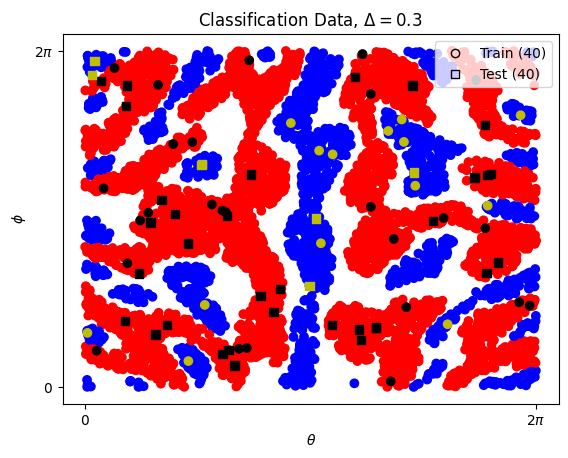

In [7]:
split_xs = lambda x: [[x[i][j] for i in range(len(x))] for j in [0, 1]]

xi, xj = split_xs(Xs)
xi_train, xj_train = split_xs(X_train)
xi_test, xj_test = split_xs(X_test)

label_circle = mlines.Line2D(
    [],
    [],
    color="none",
    marker="o",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Train ({len(X_train)})",
)
label_square = mlines.Line2D(
    [],
    [],
    color="none",
    marker="s",
    markerfacecolor="none",
    markeredgecolor="black",
    label=f"Test ({len(X_test)})",
)

plt.scatter(xi, xj, marker="o", c=["r" if v == 1.0 else "b" for v in Ys])
plt.scatter(xi_train, xj_train, c=["k" if v == 1.0 else "y" for v in Y_train])
plt.scatter(xi_test, xj_test, marker="s", c=["k" if v == 1.0 else "y" for v in Y_test])
plt.xticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.yticks([0, 2 * np.pi], [r"$0$", r"$2\pi$"])
plt.xlabel("$\\theta$")
plt.ylabel("$\phi$")
plt.legend(handles=[label_circle, label_square], loc="upper right")
plt.title(f"Classification Data, $\Delta = {delta}$")
plt.savefig(DATA_PATH + "binary_landscape.png")
plt.show()

An arbitrary single qubit state can be written:

$$ \left| \psi \right\rangle = e^{i \gamma} \big(\cos \frac{\theta}{2}\left|0\right\rangle + e^{i \phi} \sin \frac{\theta}{2}\left|1\right\rangle \big) $$ 

where $\theta$, $\phi$ and $\gamma$ are real numbers. The numbers $0 \leq \theta \leq \pi$ and $0 \leq \phi \leq 2\pi$ define a point on the Bloch sphere.

## Quantum Kernel Estimation

For the second classification protocol, we restrict ourselves to the binary label case, with $C = \left\{+1, −1\right\}$. Here it will be convenient to write $T = \left\{\textbf{x}_1,...,\textbf{x}_t\right\}$ with $t = \left|T\right|$; also let $y_i = m(\textbf{x}_i)$ be the corresponding label. In this protocol we only use the quantum computer to estimate the $t \times t$ kernel matrix $K(\textbf{x}_i, \textbf{x}_j) = \left|\langle\Phi(\textbf{x}_i)|\Phi(\textbf{x}_j)\rangle\right|^2$
, c.f. section VII. For all pairs of points $\textbf{x}_i, \textbf{x}_j \in T$ in the the training data, we sample the overlap between feature states to obtain the matrix entry in the kernel. This fidelity can be estimated from the output probability of the circuit depicted in Fig. 5.b. by sampling the output distribution with $R$ shots and only taking the $0^n$ count. The frequency of the $0^n$ count is an estimator of the Kernel entry up to an error $\epsilon = O(R^{−1/2})$. After the kernel matrix for the full training data has been constructed we use the conventional (classical) support vector machine classifier [1, 2]. The optimal hyperplane can be found by solving the dual quadratic program $L_D$ for the variables $\alpha = \left\{\alpha_i\right\}_{i=1...t}$ described in section III A eqn. (10). Hence, to train, we maximize

$$L_D(\alpha) = \sum_{i=1}^t \alpha_i - \frac{1}{2} \sum_{i,j=1}^t y_i y_j \alpha_i \alpha_j K(\textbf{x}_i, \textbf{x}_j),$$

subject to $\sum_{i=1}^t \alpha_i y_i = 0$ and $\alpha_i \geq 0$. This problem is concave, and therefore efficiently solvable, whenever $K(\textbf{x}_i, \textbf{x}_j)$ is a positive definite matrix. Standard quadratic programming solvers can be used [3]. The solution to this problem will be given by a nonnegative vector $\alpha^* = (\alpha_1^*,...,\alpha_t^*)$. Due to complementary slackness, c.f. eqn (18) we expect that many of the $\alpha_i^*$ will be zero. Hence, there will only be subset of training samples that are needed to construct the optimal hyperplane. These samples are referred to as the support vectors.

The training phase consists of the following steps:

$$K(\textbf{x}_i, \textbf{x}_j) = \left|\langle\Phi(\textbf{x}_i)|\Phi(\textbf{x}_j)\rangle\right|^2$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

In [8]:
def powerset(iterable, mx):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    pset = chain.from_iterable(combinations(s, r) for r in range(len(s) + 1))
    return [l for l in list(pset) if len(l) == mx]

In [9]:
def encode_data(x):
    """Non-linear encoding (transformation) of one input data vector

    Args:
        x : shape (2,) tensor containing one input data vector

    Returns:
        triple of data encoded coefficients phi_1, phi_2, phi_{1,2}
    """

    return x[0], x[1], (np.pi - x[0]) * (np.pi - x[1])

Considering only Ising type interactions ($d=2$), the unitaries are generated from one- and two- big gates of the form

$$U_{\phi_{\{k\}}(\textbf{x})} = \exp\big(i\phi_{\{k\}}(\textbf{x})Z_k \big)$$
$$U_{\phi_{\{l,m\}}(\textbf{x})} = \exp\big(i\phi_{\{k,l\}}(\textbf{x})Z_kZ_l\big)$$

where we have followed Havlíček et al. and chosen $\phi_{\{ i \}} = x_i$ and $\phi_{\{ 1,2 \}} = (\pi - x_1)(\pi - x_2)$ 

### Feature mapping functions

In [10]:
n_wires = 2  # number of qubits
S_size = 2  # number of interactions considered
pset = powerset(range(n_wires), S_size)

In [11]:
def ansatz(x):
    """The embedding ansatz

    Args:
        x : shape (3,) tensor containing one encoded data vector

    """
    for i in range(n_wires):
        qml.RZ(-2 * x[i], wires=i)

    for s in pset:
        qml.CNOT(wires=s)
        qml.RZ(-2 * x[2], wires=s[1])
        qml.CNOT(wires=s)

adjoint_ansatz = qml.adjoint(ansatz)

In [12]:
shots = 500  # number of circuit executions

dev = qml.device("default.qubit", wires=n_wires, shots=shots)

@qml.qnode(dev)
def kernel(x, z):
    """The quantum kernel.

    Args:
        x : shape (2,) tensor containing one input data vector
        z : shape (2,) tensor containing one input data vector
    
    """
    
    x_enc = encode_data(x)
    z_enc = encode_data(z)

    for _ in range(S_size):
        for i in range(n_wires):
            qml.Hadamard(wires=i)
        ansatz(x_enc)
    
    for _ in range(S_size):
        adjoint_ansatz(z_enc)
        for i in range(n_wires):
            qml.Hadamard(wires=i)
            
    projector = np.zeros((2**n_wires, 2**n_wires))
    projector[0, 0] = 1
    
    return qml.expval(qml.Hermitian(projector, wires=range(n_wires)))

In [13]:
print(qml.draw(kernel)(X_train[0], X_train[0]))

0: ──H──RZ(-10.10)─╭●───────────╭●──H──RZ(-10.10)─╭●───────────╭●─╭●─────────────╭●───RZ(-10.10)†──H
1: ──H──RZ(-2.34)──╰X──RZ(7.52)─╰X──H──RZ(-2.34)──╰X──RZ(7.52)─╰X─╰X†──RZ(7.52)†─╰X†──RZ(-2.34)†───H

──╭●─────────────╭●───RZ(-10.10)†──H─┤ ╭<𝓗(M0)>
──╰X†──RZ(7.52)†─╰X†──RZ(-2.34)†───H─┤ ╰<𝓗(M0)>


In [14]:
def kernel_ideal(A, B):
    """Compute the matrix whose entries are the kernel
       evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

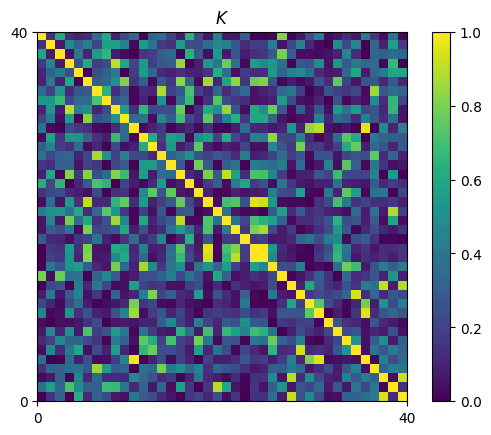

In [15]:
kernel = kernel_ideal(X_train, X_train)

im = plt.imshow(kernel, extent=(0, samples_per_set, 0, samples_per_set))
plt.colorbar(im)
plt.xticks([0, samples_per_set])
plt.yticks([0, samples_per_set])
plt.title("$K$")
plt.show()

### Quantum kernel estimation: the training phase
1. **Input** Labeled training samples $T = \left\{ \textbf{x} \in \Omega \in {\rm I\!R}^n \right\} \times \left\{ y \in C \right\}$, quadratic program solver.
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ **do**
5. $\hspace{5mm}$ **for** $\textit{j} = 1$ to $\textit{t}$ **do**
6. $\hspace{10mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{10mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{15mm}$ Run the circuit from Fig. 5.b. with paremeters $\textbf{x}_i, \textbf{x}_j$.
9. $\hspace{15mm}$ Measure outcome in $Z$-basis.
10. $\hspace{15mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{20mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{15mm}$ **end if**
13. $\hspace{10mm}$ **end for**
14. $\hspace{10mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{x}_j) = r_{0^n}R^{-1}$.
15. $\hspace{5mm}$ **end for**
16. **end for**
17. Use quadratic program solver to optimize $\alpha$ in $L_D$ in eqn. (1) with kernel $K = \hat{K}$ and set $T$.
18. **return** the final parameters $\alpha^*$ and value of the cost function $L_D$ and kernel estimator $\hat{K}$.

### Quantum kernel estimation: the classification phase
1. **Input** An unlabeled sample from the test set $\textbf{s} \in S$, optimal SVM parameters $\alpha, b$ and training data set $T$. 
2. **Parameters** Number of measurement shots $R$.
3. Calibrate the quantum hardware to generate short depth circuits.
4. **for** $\textit{i} = 1$ to $\textit{t}$ with $\alpha_i^* > 0$ **do**
5. $\hspace{5mm}$ Set the counter $r_{0^n} = 0$
7. $\hspace{5mm}$ **for** $\textit{shot} = 1$ to $R$ **do**
8. $\hspace{10mm}$ Run the circuit from Fig. 5.b. with paremeters $\textbf{x}_i, \textbf{s}$.
9. $\hspace{10mm}$ Measure outcome in $Z$-basis.
10. $\hspace{10mm}$ **if** Measurement outcome is $0^n$ **then**
11. $\hspace{15mm}$ Increase counter by one, setting $r_{0^n} \rightarrow r_{0^n} + 1$.
12. $\hspace{10mm}$ **end if**
13. $\hspace{5mm}$ **end for**
14. $\hspace{5mm}$ Construct kernel estimate $\hat{K}(\textbf{x}_i, \textbf{s}) = r_{0^n}R^{-1}$.
15. **end for**
16. **return** $\text{sign}\big(\sum_{i=1}^t y_i \alpha_i^* \hat{K}(\textbf{x}_i, \textbf{s}) + b \big)$.